In [53]:
%pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
from pathlib import Path
import seaborn as sns
import os

In [55]:
folders = glob.glob('results/*')
folders

['results/2025-05-15']

In [56]:
variants = glob.glob(f'{folders[-1]}/*/*/*/*')
variants

['results/2025-05-15/1600/0x0808/rows/lic3',
 'results/2025-05-15/1600/0x0808/rows/lic0',
 'results/2025-05-15/1600/0x0808/rows/lic2',
 'results/2025-05-15/1600/0x0808/rows/lic1',
 'results/2025-05-15/1600/0x0808/columns/lic3',
 'results/2025-05-15/1600/0x0808/columns/lic0',
 'results/2025-05-15/1600/0x0808/columns/lic2',
 'results/2025-05-15/1600/0x0808/columns/lic1',
 'results/2025-05-15/1600/0x1010/rows/lic3',
 'results/2025-05-15/1600/0x1010/rows/lic0',
 'results/2025-05-15/1600/0x1010/rows/lic2',
 'results/2025-05-15/1600/0x1010/rows/lic1',
 'results/2025-05-15/1600/0x1010/columns/lic3',
 'results/2025-05-15/1600/0x1010/columns/lic0',
 'results/2025-05-15/1600/0x1010/columns/lic2',
 'results/2025-05-15/1600/0x1010/columns/lic1',
 'results/2025-05-15/1600/0x1919/rows/lic3',
 'results/2025-05-15/1600/0x1919/rows/lic0',
 'results/2025-05-15/1600/0x1919/rows/lic2',
 'results/2025-05-15/1600/0x1919/rows/lic1',
 'results/2025-05-15/1600/0x1919/columns/lic3',
 'results/2025-05-15/1600/0x

In [57]:
def read_from_folder(folder: str) -> pd.DataFrame:
    """
    folder: The folder that contains the measurements for the different number of cores.
    """
    df = pd.DataFrame()

    for file in glob.glob(f'{folder}/*'):
        num_cores = int(Path(file).stem) + 1
        read_df = pd.read_csv(file)

        for _index, row in read_df.iterrows():
            metric = row['metric']
            value = row['average']
            df = pd.concat([df, pd.DataFrame([{'metric': metric, 'value': value, 'core_count': num_cores}])])

    return df

In [58]:
data = pd.DataFrame()

for variant in variants:
    row = read_from_folder(variant)
    _, _, core_frequency, uncore_frequency, population_order, license = variant.split('/')
    row['core_frequency'] = core_frequency
    row['uncore_frequency'] = uncore_frequency
    row['population_order'] = population_order
    row['license'] = license
    data = pd.concat([data, row])

data

,metric,value,core_count,core_frequency,uncore_frequency,population_order,license
0,ipc-estimate,2.30749,1,1600,0x0808,rows,lic3
0,perf-freq,1.59247,1,1600,0x0808,rows,lic3
0,perf-ipc,2.89819,1,1600,0x0808,rows,lic3
0,sysfs-powercap-rapl,219.83600,1,1600,0x0808,rows,lic3
0,sysfs-powercap-rapl/package-0,95.66770,1,1600,0x0808,rows,lic3
...,...,...,...,...,...,...,...
0,sysfs-powercap-rapl,219.85700,3,800,0x0819,columns,lic1
0,sysfs-powercap-rapl/package-0,95.55100,3,800,0x0819,columns,lic1
0,sysfs-powercap-rapl/package-0-dram,12.05500,3,800,0x0819,columns,lic1
0,sysfs-powercap-rapl/package-1,101.03100,3,800,0x0819,columns,lic1


In [59]:
working_data = data
working_data = working_data.pivot_table(index=['license', 'core_count', 'core_frequency', 'uncore_frequency', 'population_order'], values='value', columns=['metric'])
working_data['freq_times_power'] = working_data['sysfs-powercap-rapl/package-0'] / working_data['perf-freq']
working_data = working_data.reset_index()

population_order_to_name = {
    'rows': 'rows',
    'columns': 'columns',
}

license_level_to_name = {
    'lic0': 'SSE2',
    'lic1': 'AVX2',
    'lic2': 'AVX512',
    'lic3': 'AMX'
}

POPULATION_ORDER_NAME = 'Population order'
LIC_NAME = 'License name'
VARIANT_NAME = 'Variant'
CORE_COUNT_NAME = 'Number of active cores'
LICENSE_NAME = 'Used cdyn class'
POWER_WATT_NAME = 'Power draw of package 0 [W]'
CORE_FREQUENCY_NAME = 'Average frequency of running cores [GHz]'


CORE_COUNT = 'Number of active cores'
MAX_TURBO_FREQ = 'Maximum opportunistic turbo frequency [MHz]'
POWER_WATT = 'Power draw of package 0 [W]'


working_data[POPULATION_ORDER_NAME] = working_data['population_order'].apply(lambda v: population_order_to_name[v])
working_data[LIC_NAME] = working_data['license'].apply(lambda v: license_level_to_name[v])
working_data[VARIANT_NAME] = working_data['license'] + " " + working_data['population_order']
working_data[CORE_COUNT_NAME] = working_data['core_count']
working_data[LICENSE_NAME] = working_data['license']

working_data[POWER_WATT_NAME] = working_data['sysfs-powercap-rapl/package-0']
working_data[CORE_FREQUENCY_NAME] = working_data['perf-freq']

working_data

metric,license,core_count,core_frequency,uncore_frequency,population_order,ipc-estimate,perf-freq,perf-ipc,sysfs-powercap-rapl,sysfs-powercap-rapl/package-0,...,sysfs-powercap-rapl/package-1,sysfs-powercap-rapl/package-1-dram,freq_times_power,Population order,License name,Variant,Number of active cores,Used cdyn class,Power draw of package 0 [W],Average frequency of running cores [GHz]
0,lic0,1,1600,0x0808,columns,1.91436,1.59394,2.40164,219.954,95.7376,...,100.933,11.2240,60.063490,columns,SSE2,lic0 columns,1,lic0,95.7376,1.59394
1,lic0,1,1600,0x0808,rows,1.91416,1.59368,2.40165,219.981,95.8005,...,100.862,11.2361,60.112758,rows,SSE2,lic0 rows,1,lic0,95.8005,1.59368
2,lic0,1,1600,0x0819,columns,1.91443,1.59401,2.40167,220.015,95.7343,...,101.029,11.2502,60.058783,columns,SSE2,lic0 columns,1,lic0,95.7343,1.59401
3,lic0,1,1600,0x0819,rows,1.91410,1.59425,2.40149,220.725,96.1126,...,101.389,11.2431,60.287032,rows,SSE2,lic0 rows,1,lic0,96.1126,1.59425
4,lic0,1,1600,0x1010,columns,1.91548,1.59475,2.40178,268.093,119.5420,...,125.314,11.2480,74.959712,columns,SSE2,lic0 columns,1,lic0,119.5420,1.59475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7163,lic3,56,performance,0x0819,rows,2.99050,2.06908,2.89159,559.624,351.3050,...,184.434,11.2006,169.788022,rows,AMX,lic3 rows,56,lic3,351.3050,2.06908
7164,lic3,56,performance,0x1010,columns,3.09599,2.15288,2.89162,503.728,352.1780,...,127.678,11.2572,163.584594,columns,AMX,lic3 columns,56,lic3,352.1780,2.15288
7165,lic3,56,performance,0x1010,rows,2.99727,2.08192,2.89248,506.493,353.2570,...,129.397,11.2182,169.678470,rows,AMX,lic3 rows,56,lic3,353.2570,2.08192
7166,lic3,56,performance,0x1919,columns,3.07078,2.13026,2.89289,559.223,350.9660,...,184.247,11.2727,164.752659,columns,AMX,lic3 columns,56,lic3,350.9660,2.13026


In [60]:
hue_to_color = {
    "AMX": sns.color_palette()[0],
    "AVX512": sns.color_palette()[1],
    "AVX2": sns.color_palette()[2],
    "SSE2": sns.color_palette()[3]
}
hue_order=list(hue_to_color.keys())

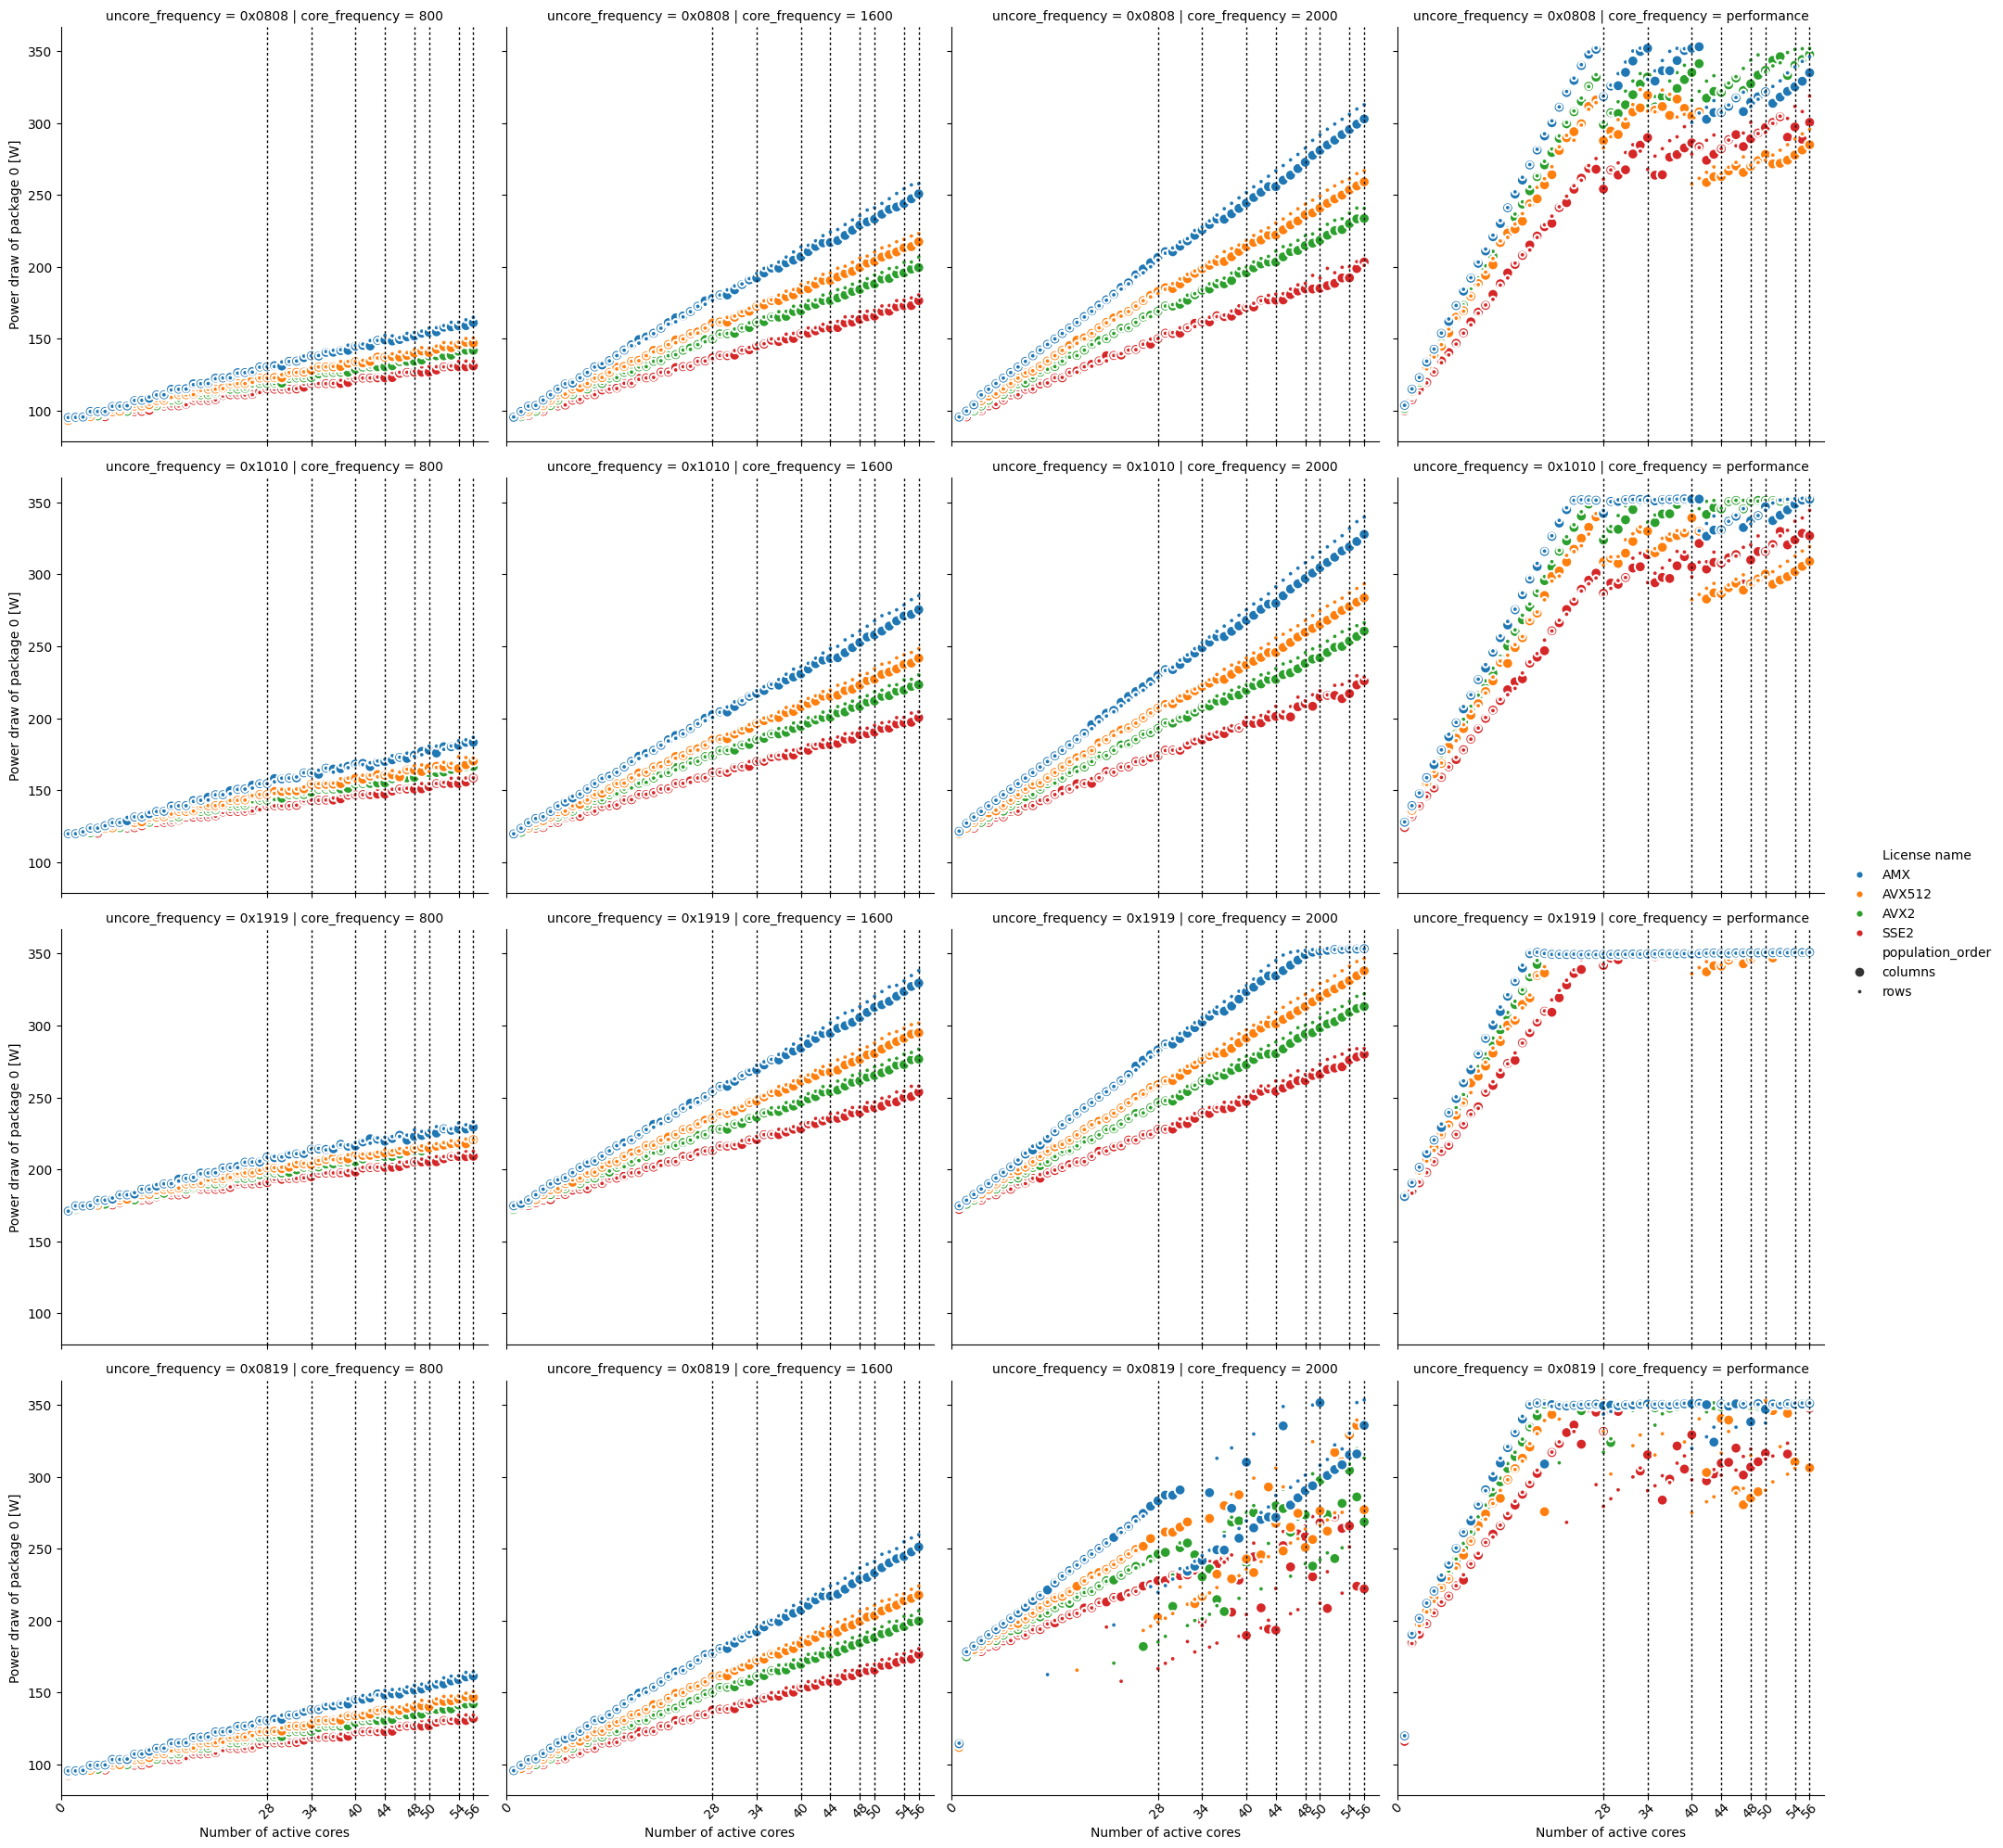

In [61]:
g = sns.FacetGrid(working_data, col="core_frequency",  row="uncore_frequency", height=5, row_order=["0x0808", "0x1010", "0x1919", "0x0819"], col_order=["800", "1600", "2000", "performance"])
g.map(sns.scatterplot, CORE_COUNT_NAME, POWER_WATT_NAME, LIC_NAME, "population_order", linewidth=1.5, hue_order=hue_order)

g.add_legend()

buckets = [28,34,40,44,48,50,54,56]
for axi in g.axes:
    for axj in axi:
        for i in buckets:
            axj.axvline(x=i, color='black', dashes=[2], linewidth=1)
            axj.set_xlim(0, 58)
            axj.set_xticks([0] + buckets)
            axj.tick_params(axis='x', pad=0, rotation=45)

plt.savefig('../../thesis/fig/core-power-regulators-package-power.pdf', bbox_inches='tight')

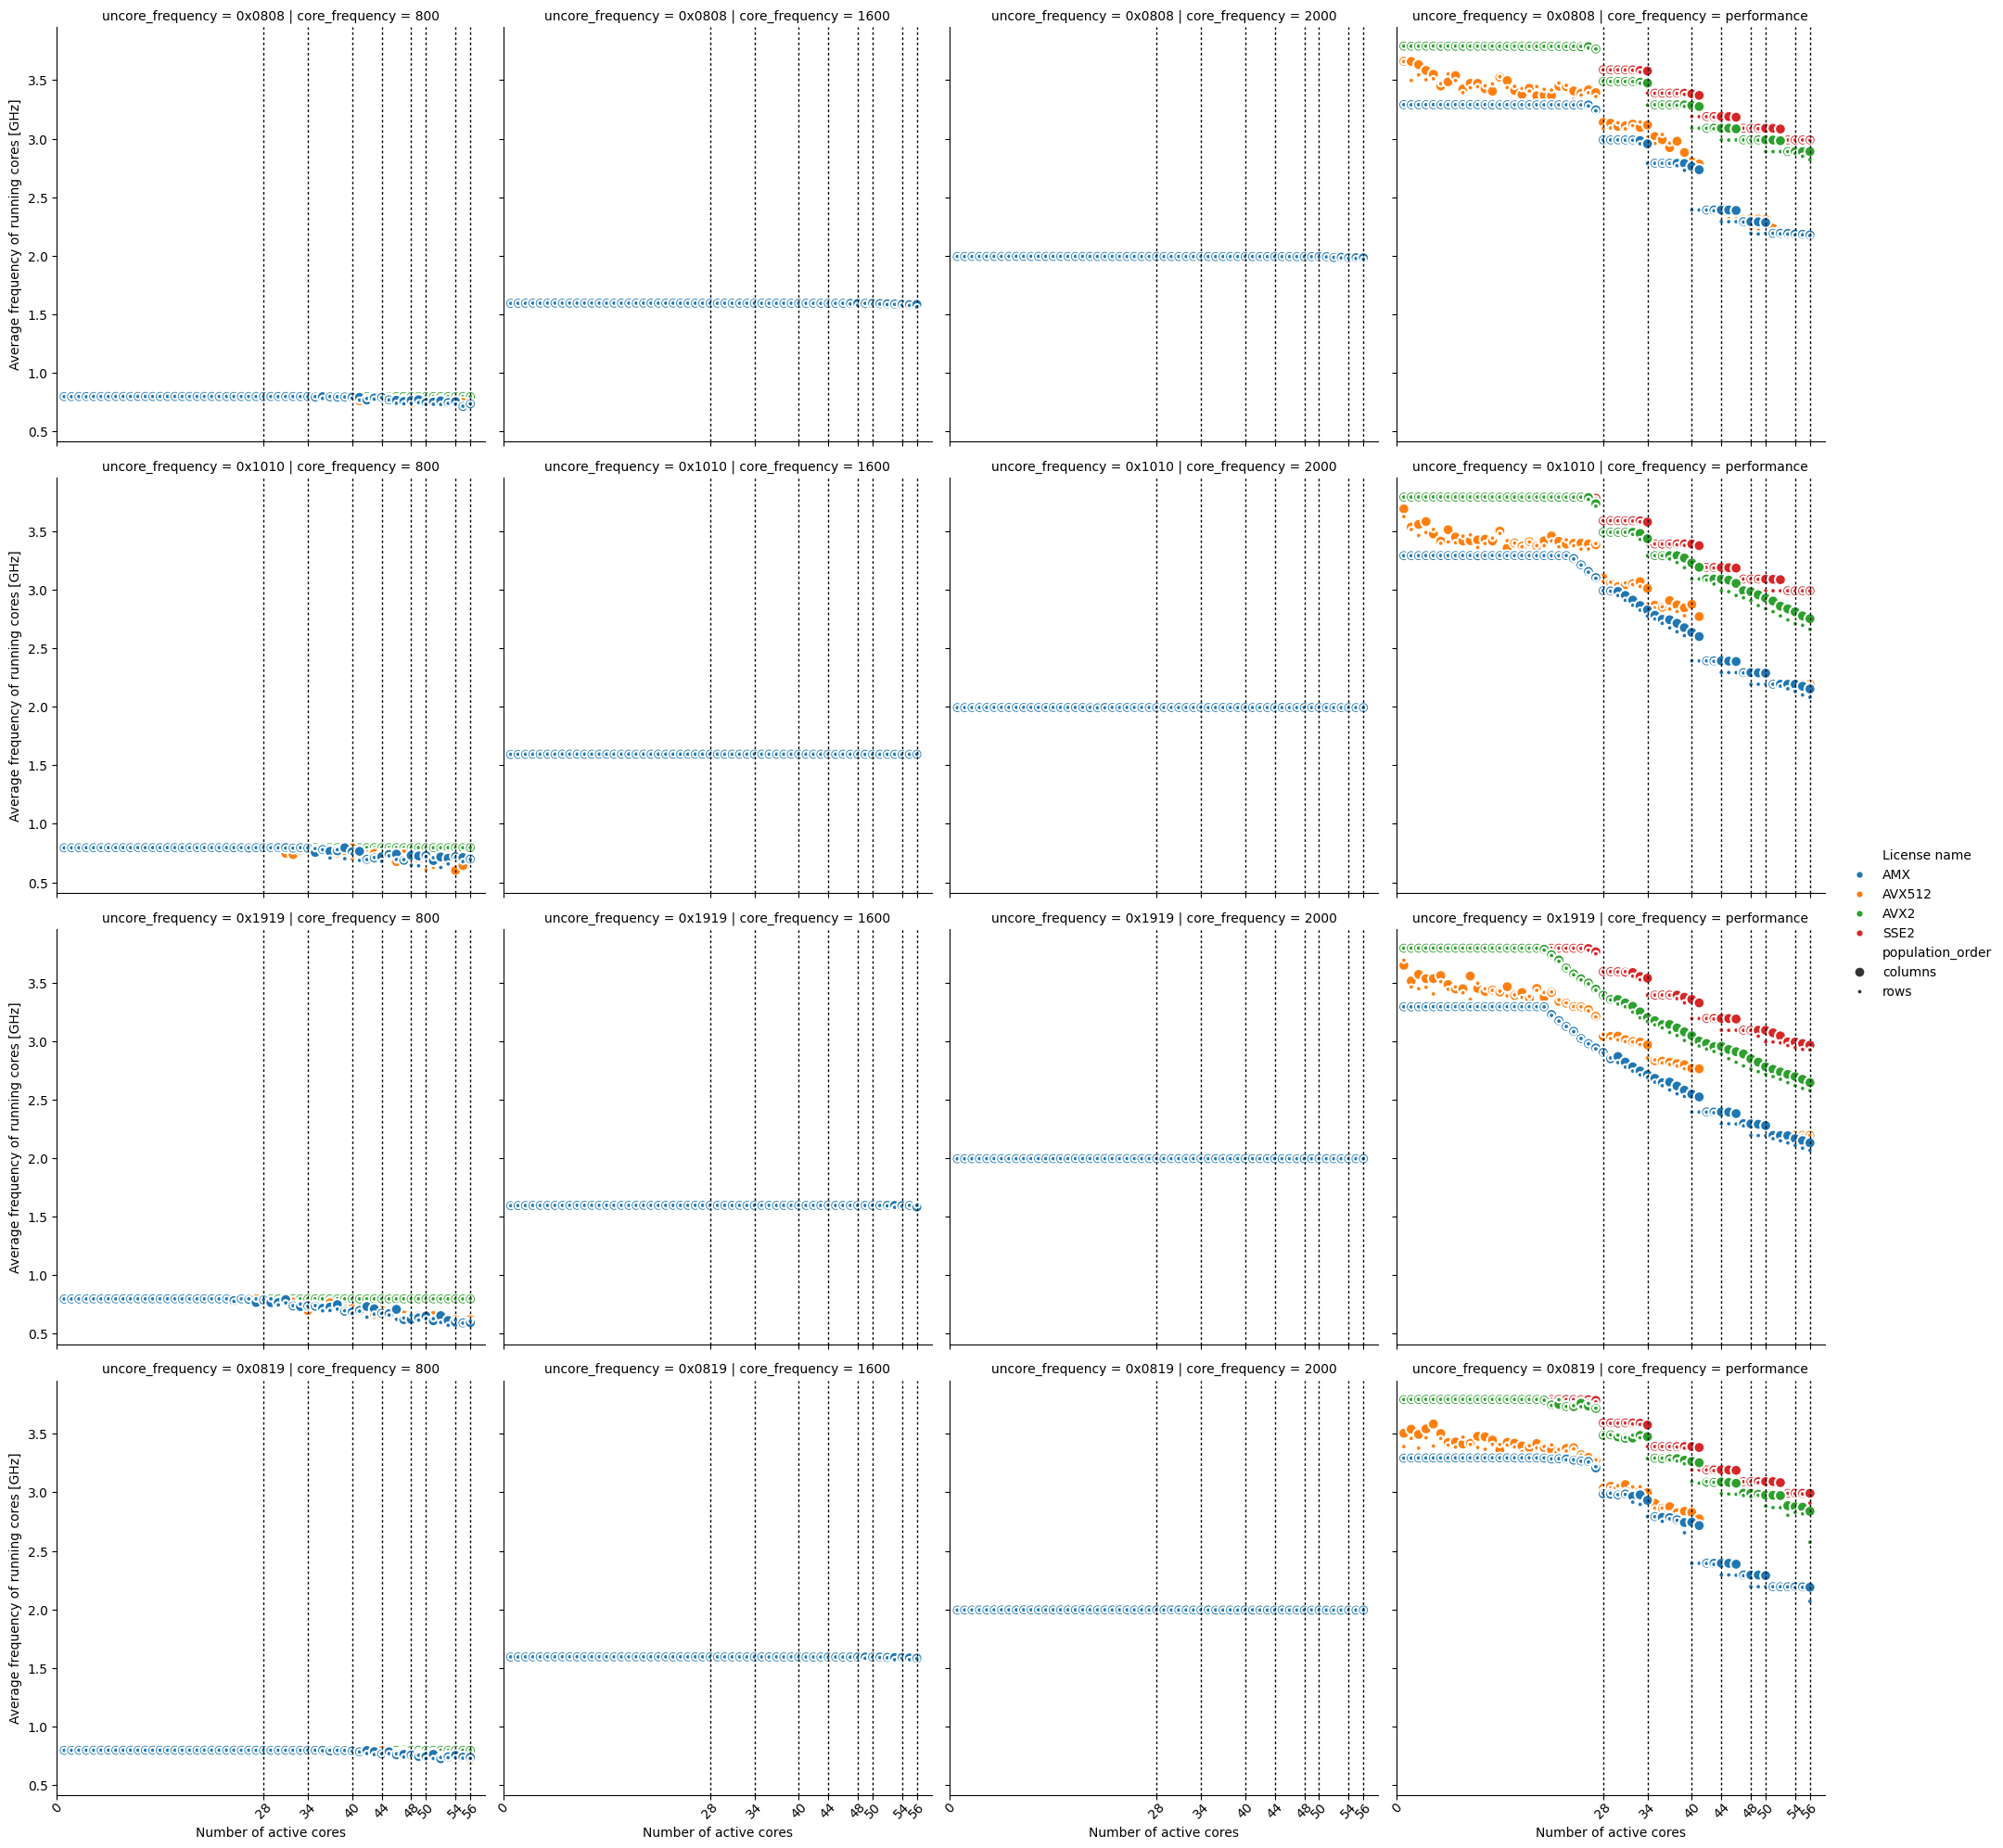

In [62]:
g = sns.FacetGrid(working_data, col="core_frequency",  row="uncore_frequency", height=5, row_order=["0x0808", "0x1010", "0x1919", "0x0819"], col_order=["800", "1600", "2000", "performance"])
g.map(sns.scatterplot, CORE_COUNT_NAME, CORE_FREQUENCY_NAME, LIC_NAME, "population_order", linewidth=1.5, hue_order=hue_order)
g.add_legend()

buckets = [28,34,40,44,48,50,54,56]
for axi in g.axes:
    for axj in axi:
        for i in buckets:
            axj.axvline(x=i, color='black', dashes=[2], linewidth=1)
            axj.set_xlim(0, 58)
            axj.set_xticks([0] + buckets)
            axj.tick_params(axis='x', pad=0, rotation=45)

plt.savefig('../../thesis/fig/core-power-regulators-core-frequency.pdf', bbox_inches='tight')